In [1]:
!pip install -qr requirements.txt

You should consider upgrading via the 'C:\Users\dooli\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [2]:
# %load_ext pyflame

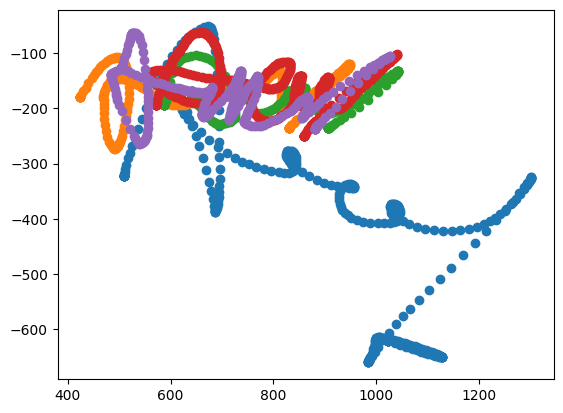

In [3]:
import numpy as np
import json

from sigma_lognormal.plotting import *

from sigma_lognormal.preprocess import preprocess

with open("data/signatures.txt") as f:
	signatures = json.load(f)
	np_signatures = [np.array(signature) for signature in signatures]

signals = [preprocess(np_signature) for np_signature in np_signatures]
show_plot("signals",signals)

signal = signals[-1]

In [4]:
# !pip install --upgrade scipy==1.8.0
import scipy
assert scipy.__version__ == "1.8.0"

In [5]:
import torch
print(torch.__version__)


1.13.1+cpu


In [6]:
print(len(signal.position),len(signal.velocity))

398 397


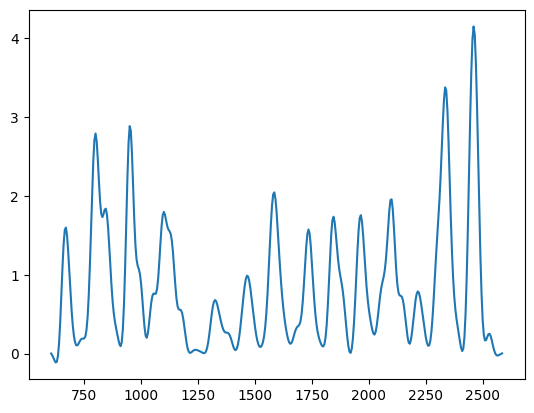

In [7]:
import matplotlib.pyplot as plt

show_plot("speeds",[signal],should_scatter=False)

LognormalStroke(D=90.60068766424061,t_0=614.6571050391253,mu=4.0890331386424705,sigma=0.4125235053022321,theta_s=-0.4749339843264432,theta_f=-2.7814265891366876)


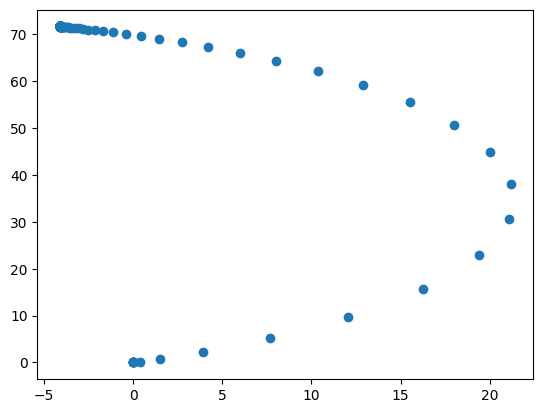

In [8]:
from sigma_lognormal.speed_extract import extract_sigma_lognormal, get_point_combos, get_stroke_combos, mark_stroke_candidates

candidates=mark_stroke_candidates(signal)

candidate=candidates[0]
point_combos=get_point_combos(candidate)
point_combo = point_combos[0]

stroke_combos = get_stroke_combos(candidate)
stroke_combo = stroke_combos[0]

lognormal = extract_sigma_lognormal(point_combo,stroke_combo)
print(lognormal)
show_plot("signals",[lognormal.signal(signal.time)])

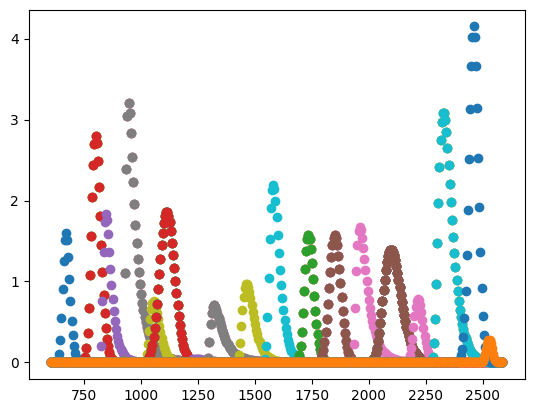

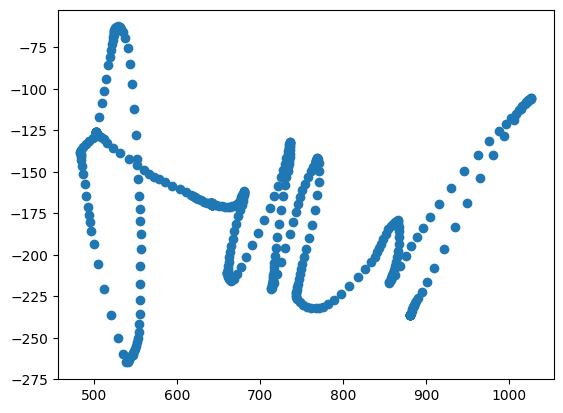

In [9]:
from sigma_lognormal.speed_extract import extract_all_lognormals

lognormals = extract_all_lognormals(signal)

show_plot("speeds",[lgn.signal(signal.time) for lgn in lognormals])
show_plot("signals",[signal])


In [10]:
np.array(0).shape

()

In [11]:
from sigma_lognormal.beam_search import BeamSearch
from sigma_lognormal.action_plan import ActionPlan

top_k = 2
snr_threshold = 25
max_strokes = 30
search = BeamSearch(signal,top_k,snr_threshold,max_strokes)

demo_plan = ActionPlan([],signal.position[0])

suggest_plans = search.get_next_action_plans([demo_plan])


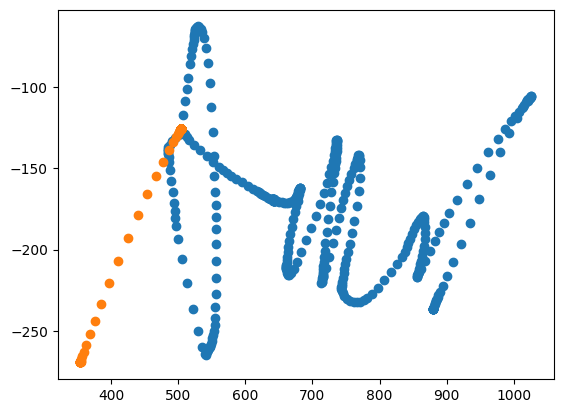

In [12]:
suggest_plan = suggest_plans[0]
show_plot("signals",[signal,suggest_plan.signal(signal.time)])

In [13]:
# # %%pyflame
# out_plan,snr_plot = search.search()
# out_signal = out_plan.signal(signal.time)

In [14]:
# plt.plot(np.arange(1,1+len(snr_plot)),snr_plot)
# plt.title("Best SNR vs. Stroke Number")
# plt.show()

In [15]:
# import json
# with open("cached_plan.json","w") as f:
# 	json.dump(out_plan.to_json(),f)

In [16]:
import json
out_plan = ActionPlan.from_json(json.load(open("cached_plan.json")))

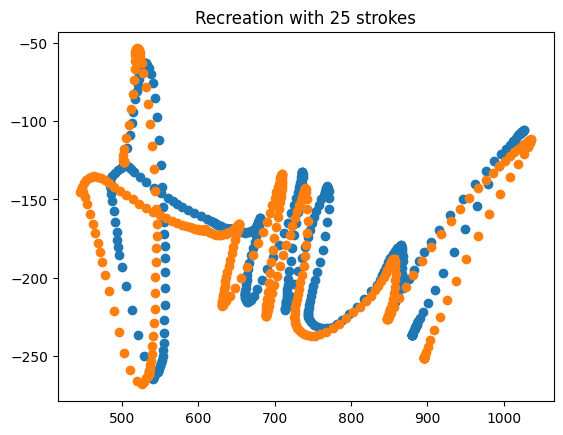

In [17]:
small_plan = out_plan.sub_plan(25)
small_signal = small_plan.signal(signal.time)
plt.title("Recreation with "+str(len(small_plan.strokes))+" strokes")
show_plot("signals",[signal,small_signal])

In [18]:
sample_range = 	slice(15)
plt.title("Recreated velocity profile, SNR "+str(round(snr_plot[-1],2)))
show_plot("signals",[signal[sample_range],small_signal[sample_range]])

NameError: name 'snr_plot' is not defined

In [ ]:
# animate_plot("signals",[signal,out_signal])

In [ ]:
# stroke_signals = [stroke.signal(signal.time)+out_plan.signal(np.array([stroke.t_0,stroke.t_0])).position[0] for stroke in out_plan.strokes]

# animate_plot("signals",[signal,*stroke_signals])

# # TODO: fix the angle and MSE calculations. They might be bad/not line up with position because of preprocessing+padding.

NameError: name 'stroke_signals' is not defined

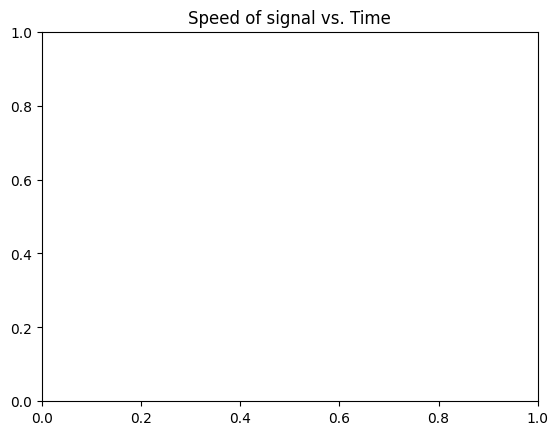

In [ ]:
plt.title("Speed of signal vs. Time")
show_plot("signals",[signal,*stroke_signals])

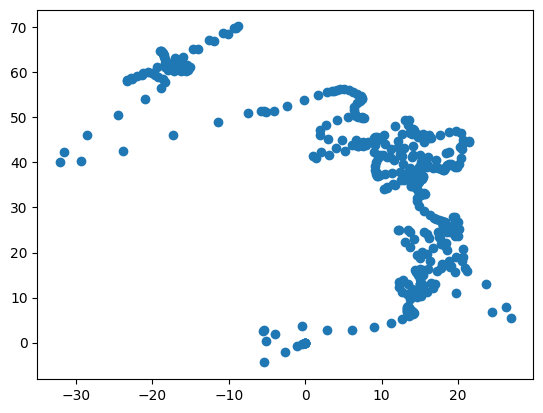

In [ ]:
show_plot("signals",[signal - out_signal])

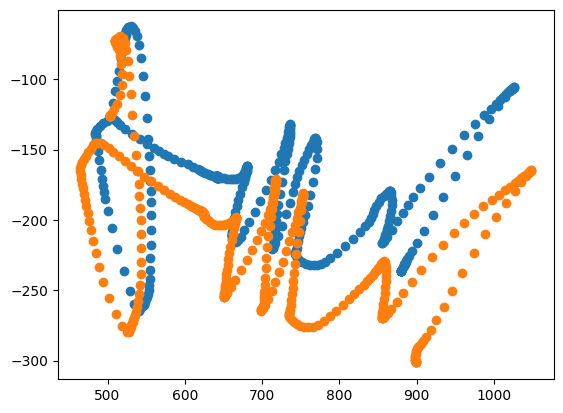

In [ ]:
show_plot("signals",[signal,out_signal])

In [22]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
%autoreload 2
from pytorch.pt_action_plan import DiffActionPlan
from sigma_lognormal.signals import Signal
# torch.autograd.detect_anomaly()

target_signal = Signal(
	torch.from_numpy(signal.position),
	torch.from_numpy(signal.velocity),
	torch.from_numpy(signal.angle),
	torch.from_numpy(signal.speed),
	torch.from_numpy(signal.time)
)

tuning_plan = DiffActionPlan(out_plan)
# tuning_plan.strokes = tuning_plan.strokes[:1]
print([stroke.mu for stroke in tuning_plan.strokes])



[Parameter containing:
tensor(4.4268, requires_grad=True), Parameter containing:
tensor(7.2040, requires_grad=True), Parameter containing:
tensor(4.9390, requires_grad=True), Parameter containing:
tensor(3.6803, requires_grad=True), Parameter containing:
tensor(5.9851, requires_grad=True), Parameter containing:
tensor(4.0967, requires_grad=True), Parameter containing:
tensor(5.2506, requires_grad=True), Parameter containing:
tensor(5.9741, requires_grad=True), Parameter containing:
tensor(3.9350, requires_grad=True), Parameter containing:
tensor(4.9789, requires_grad=True), Parameter containing:
tensor(4.2754, requires_grad=True), Parameter containing:
tensor(4.7259, requires_grad=True), Parameter containing:
tensor(4.1511, requires_grad=True), Parameter containing:
tensor(6.2812, requires_grad=True), Parameter containing:
tensor(3.9479, requires_grad=True), Parameter containing:
tensor(6.2812, requires_grad=True), Parameter containing:
tensor(4.8767, requires_grad=True), Parameter con

In [59]:

from torch.optim import Adam
from torch.nn import MSELoss

criterion = MSELoss()
lr = 0.0001

optimizer = Adam(tuning_plan.parameters(),lr=lr)

def vel_loss(target_signal,plan_signal):
	return criterion(target_signal.velocity,plan_signal.velocity)

def pos_loss(target_signal,plan_signal):
	return criterion(target_signal.position,plan_signal.position)

vel_weight = 0.5
pos_weight = 0.5
def full_loss(target_signal,plan_signal):
	return vel_weight*vel_loss(target_signal,plan_signal) + pos_weight*pos_loss(target_signal,plan_signal)

num_iters = 100
for i in range(num_iters):
	optimizer.zero_grad()
	plan_signal = tuning_plan(target_signal.time)
	loss = full_loss(target_signal,plan_signal)
	loss.backward()
	optimizer.step()
	if i % 10 == 0:
		print("Loss: "+str(loss.item()))
	# break

Loss: 228.47253160197482
Loss: 214.5909835171635
Loss: 201.76015085333032
Loss: 189.9326456070487
Loss: 179.04721221547499
Loss: 169.0421019315593
Loss: 159.80983717804793
Loss: 151.24075686355252
Loss: 143.24011760216723
Loss: 135.7275279893594


In [ ]:
tuned_out_plan = tuning_plan.to_action_plan()

# plot the tuned plan
tuned_out_signal = tuned_out_plan.signal(signal.time)


In [54]:
stroke = tuning_plan.strokes[0]
stroke.time_param_1_test

Parameter containing:
tensor(1.0000e-04, requires_grad=True)

In [ ]:
torch.tensor(out_plan.strokes[0].t_0)

tensor(2251.0037, dtype=torch.float64)